**Classification of chest X-Rays using ViT model**

This notebook describes the fine-tuning of ViT model in classification of chest X-Rays. The notebook is primarily inspired from https://www.ziyi-zhou.com/#research. However, considerable changes were made in terms of model, dataset and evaluations.

In [1]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device = ', device)

device =  cuda


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nidhinthomas0624","key":"d6e5eff4aa05d298587978307fc26023"}'}

In [3]:
!pip install kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset

100% 1.19G/1.19G [00:42<00:00, 29.0MB/s]
100% 1.19G/1.19G [00:42<00:00, 30.2MB/s]


In [6]:
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0446-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0447-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0448-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0449-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0450-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0451-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0452-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0453-0001-0002.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0453-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack

In [9]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.7 MB/s eta 0:00:00


In [7]:
from huggingface_hub import notebook_login
notebook_login()

In [10]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision as tv
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import time
import os
import copy
import requests
import io

plt.ion()

import timm

In [11]:
import transformers
print(transformers.__version__)

4.35.2


In [12]:
all_vit_models = timm.list_models('*vit*', pretrained=True)

['convit_base.fb_in1k',
 'convit_small.fb_in1k',
 'convit_tiny.fb_in1k',
 'crossvit_9_240.in1k',
 'crossvit_9_dagger_240.in1k',
 'crossvit_15_240.in1k',
 'crossvit_15_dagger_240.in1k',
 'crossvit_15_dagger_408.in1k',
 'crossvit_18_240.in1k',
 'crossvit_18_dagger_240.in1k',
 'crossvit_18_dagger_408.in1k',
 'crossvit_base_240.in1k',
 'crossvit_small_240.in1k',
 'crossvit_tiny_240.in1k',
 'davit_base.msft_in1k',
 'davit_small.msft_in1k',
 'davit_tiny.msft_in1k',
 'efficientvit_b0.r224_in1k',
 'efficientvit_b1.r224_in1k',
 'efficientvit_b1.r256_in1k',
 'efficientvit_b1.r288_in1k',
 'efficientvit_b2.r224_in1k',
 'efficientvit_b2.r256_in1k',
 'efficientvit_b2.r288_in1k',
 'efficientvit_b3.r224_in1k',
 'efficientvit_b3.r256_in1k',
 'efficientvit_b3.r288_in1k',
 'efficientvit_l1.r224_in1k',
 'efficientvit_l2.r224_in1k',
 'efficientvit_l2.r256_in1k',
 'efficientvit_l2.r288_in1k',
 'efficientvit_l2.r384_in1k',
 'efficientvit_l3.r224_in1k',
 'efficientvit_l3.r256_in1k',
 'efficientvit_l3.r320_in1

In [13]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""

            {value}

    """.format(value=value, max=max))

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# Before you do the following, make sure to first upload a Kaggle token json
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

!mkdir -p /content/drive/MyDrive/Kaggle/CoronaHack
%cd /content/drive/MyDrive/Kaggle/CoronaHack

# Download dataset from Kaggle
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset
!unzip \*.zip  && rm *.zip

/content/drive/MyDrive/Kaggle/CoronaHack
coronahack-chest-xraydataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  coronahack-chest-xraydataset.zip
replace Chest_xray_Corona_Metadata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [17]:
metadata_path = "/content/Chest_xray_Corona_Metadata.csv"
metadata = pd.read_csv(metadata_path, index_col=0)
metadata.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [18]:
normal_meta = metadata[metadata["Label"] == "Normal"]
virus_meta = metadata[metadata["Label_1_Virus_category"] == "Virus"]
print(normal_meta.shape[0], virus_meta.shape[0])

1576 1555


In [19]:
data_dir = "/content/data1"
!mkdir $data_dir
normal_dir = f"{data_dir}/normal"
virus_dir = f"{data_dir}/virus"
dir_dict = {
    normal_dir: normal_meta,
    virus_dir: virus_meta,
}
for dir in dir_dict.keys():
  if not os.path.exists(dir):
    os.mkdir(dir)
old_data_dir = "/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"

for dir, meta in dir_dict.items():
  for im in meta["X_ray_image_name"]:
    if os.path.exists(f"{old_data_dir}/train/{im}"):
      os.rename(f"{old_data_dir}/train/{im}", f"{dir}/{im}")
    elif os.path.exists(f"{old_data_dir}/test/{im}"):
      os.rename(f"{old_data_dir}/test/{im}", f"{dir}/{im}")

In [20]:
# config
input_size = 3, 128, 128
img_size = 128
num_classes = 2
batch_size = 32

interpolation = 'bicubic'
IMAGENET_DEFAULT_MEAN  = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
DEFAULT_CROP_PCT = 0.9

In [21]:
data_dir = "/content/data1"
from timm.data import create_dataset, create_loader
# create the train and eval datasets
train_dataset = create_dataset(name='', root=data_dir, split='train', is_training=True,
        batch_size=batch_size)
val_dataset = create_dataset(name='', root=data_dir, split='validation',
                              is_training=False, batch_size=batch_size)
train_len, val_len = len(train_dataset), len(val_dataset)

# create data loaders
loader_train = create_loader(
        train_dataset,
        input_size=input_size,
        batch_size=batch_size,
        is_training=True,
        scale=[0.08, 1.0],
        ratio=[3./4., 4./3.],
        interpolation=interpolation,
        mean=IMAGENET_DEFAULT_MEAN,
        std=IMAGENET_DEFAULT_STD,
        num_workers=2)

loader_val = create_loader(
        val_dataset,
        input_size=input_size,
        batch_size=batch_size,
        is_training=False,
        interpolation=interpolation,
        mean=IMAGENET_DEFAULT_MEAN,
        std=IMAGENET_DEFAULT_STD,
        crop_pct=DEFAULT_CROP_PCT)

In [22]:
data_dir = "/content/data1"
data_transforms = transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)
    ])

image_datasets = datasets.ImageFolder(data_dir, data_transforms)

In [23]:
dataset_sizes = len(image_datasets)
class_names = image_datasets.classes
print(dataset_sizes, class_names)

3131 ['normal', 'virus']


In [24]:
val_size = int(dataset_sizes*0.15)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_datasets, [dataset_sizes-2*val_size, val_size, val_size], generator=torch.Generator().manual_seed(42))
train_len, val_len = len(train_dataset), len(val_dataset)

print(train_len, val_len)

2193 469


In [25]:
train_dataset.dataset.classes

['normal', 'virus']

In [26]:
loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True)
loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=False)

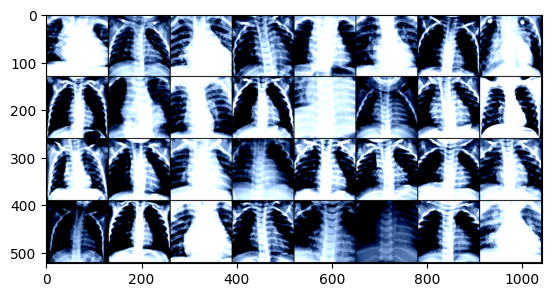

In [27]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(loader_train))

# Make a grid from batch
out = tv.utils.make_grid(inputs)

imshow(out)

In [28]:
def eval_corona(model, loader_val):
  model.eval()

  preds = []
  with torch.no_grad():
    for x, t in loader_val:
      x, t = x.to(device), t.to(device) # comment this line if use option1 dataloader
      logits = model(x)
      preds.append(torch.sum(torch.max(logits, dim=1)[1] == t))

  return sum(preds) / val_len

In [29]:
model = timm.create_model('vit_base_resnet50_224_in21k', pretrained=True, num_classes=num_classes, img_size=img_size)
model.to(device)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_resnet50_224_in21k to current vit_base_r50_s16_224.orig_in21k.
  model = create_fn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/392M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): HybridEmbed(
    (backbone): ResNetV2(
      (stem): Sequential(
        (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
        (norm): GroupNormAct(
          32, 64, eps=1e-05, affine=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
      )
      (stages): Sequential(
        (0): ResNetStage(
          (blocks): Sequential(
            (0): Bottleneck(
              (downsample): DownsampleConv(
                (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (norm): GroupNormAct(
                  32, 256, eps=1e-05, affine=True
                  (drop): Identity()
                  (act): Identity()
                )
              )
              (conv1): StdConv2dSame(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [30]:
def add_weight_decay(model, weight_decay=1e-5, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list:
            no_decay.append(param)
        else:
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]

# weight_decay
skip = {}
if hasattr(model, 'no_weight_decay'):
    skip = model.no_weight_decay()
parameters = add_weight_decay(model, 0.0001, skip)
weight_decay = 0.

optimizer = optim.SGD(parameters, momentum=0.9, nesterov=True, lr=0.01, weight_decay=weight_decay)

In [31]:
from timm.loss import LabelSmoothingCrossEntropy
loss_fn = LabelSmoothingCrossEntropy(smoothing=0.1).cuda()

In [32]:
from timm.scheduler import StepLRScheduler
# setup learning rate schedule and starting epoch
start_epoch = 0

num_epochs = 10

noise_range = None
lr_scheduler = StepLRScheduler(optimizer, decay_t=30, decay_rate=0.1,
               warmup_lr_init=0.0001, warmup_t=3, noise_range_t=None, noise_pct=0.67,
               noise_std=1., noise_seed=42)

In [33]:
iters = 10

pb_train = display(progress(0, iters), display_id=True)
losses = [[]]
accus_train = [[]]
accus_val = []

for i in range(iters):
  for x, t in loader_train:
    x, t = x.to(device), t.to(device) # comment this line if use option1 dataloader
    logits = model(x)
    loss = loss_fn(logits, t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses[-1].append(loss.item())

    with torch.no_grad():
      accus_train[-1].append(torch.sum(torch.max(logits, dim=1)[1] == t))

  losses[-1] = sum(losses[-1])
  losses.append([])
  accus_train[-1] = sum(accus_train[-1]) / train_len
  accus_train.append([])

  # step LR for next epoch
  lr_scheduler.step(i + 1)

  accus_val.append(eval_corona(model, loader_val))
  model.train()

  pb_train.update(progress(i, iters))
  print(f'\r[Step {i+1}] loss={loss:.2e} '
        f'\r[Step {i+1}] loss={losses[-2]:.2e} '
        f'train accu={accus_train[-2]:.2%} '
        f'validation accu={accus_val[-1]:.2%} '
        # , end=''
        , flush=True)
  # break

[Step 1] loss=2.93e+01 train accu=86.96% validation accu=92.32% 
[Step 2] loss=4.54e+01 train accu=60.69% validation accu=76.55% 
[Step 3] loss=3.57e+01 train accu=77.61% validation accu=80.17% 
[Step 4] loss=2.67e+01 train accu=88.65% validation accu=87.42% 
[Step 5] loss=2.48e+01 train accu=90.88% validation accu=71.64% 
[Step 6] loss=2.38e+01 train accu=91.52% validation accu=90.62% 
[Step 7] loss=2.22e+01 train accu=92.66% validation accu=92.75% 
[Step 8] loss=2.15e+01 train accu=93.43% validation accu=92.54% 
[Step 9] loss=2.16e+01 train accu=93.21% validation accu=89.13% 
[Step 10] loss=2.09e+01 train accu=93.94% validation accu=91.90% 


In [45]:
accus_train_list = [i.cpu().numpy() for i in accus_train[:-1]]

In [47]:
accus_val_list = [i.cpu().numpy() for i in accus_val]

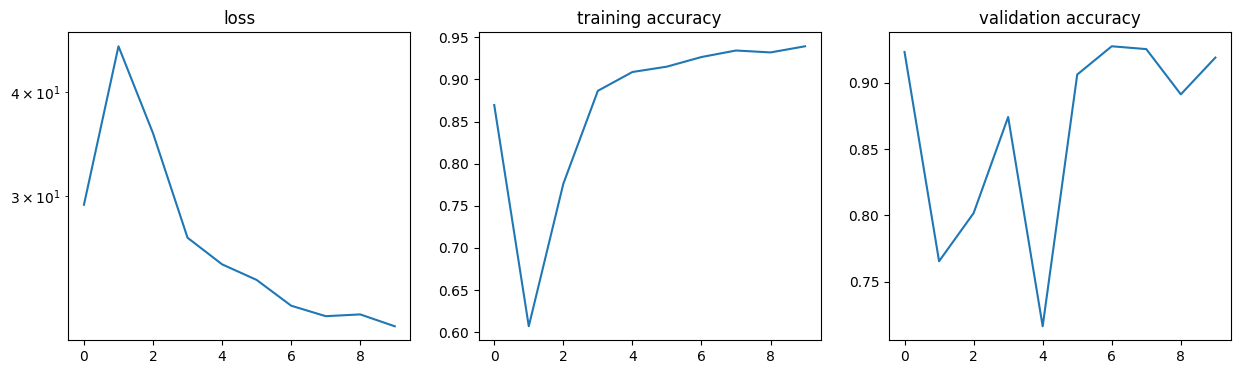

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.plot(losses[:-1])
ax1.set_yscale('log')
ax1.set_title('loss')
ax2.plot(accus_train_list)
ax2.set_title('training accuracy')
ax3.plot(accus_val_list)
ax3.set_title('validation accuracy');

In [49]:
model.eval()

loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)
preds = []
with torch.no_grad():
  for x, t in loader_test:
    x, t = x.to(device), t.to(device)
    logits = model(x)
    preds.append(torch.sum(torch.max(logits, dim=1)[1] == t))

accus_test = sum(preds) / len(test_dataset)
print(accus_test)

tensor(0.9190, device='cuda:0')


In [50]:
!mkdir -p "/content/drive/MyDrive/Kaggle/CoronaHack"

In [51]:
save_path = "/content/drive/MyDrive/Kaggle/CoronaHack/vit_10.pth"
torch.save(model, save_path)